In [1]:
import networkx as nx
import random
random.seed(42)

In [2]:
import numpy as np
np.random.seed(42)
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

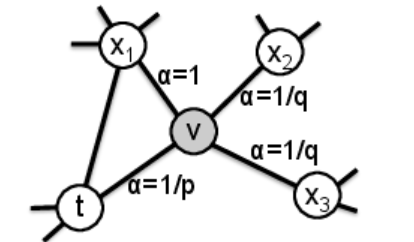

In [17]:
def get_next_node(prev,curr,p,q):
    neighbours =  list(G.neighbors(curr))
    weights = []
    sums=0
    for n in neighbours:
        if G.has_edge(n, prev):
            weights.append(1)
            sums+=1
        elif n==prev:
            weights.append(1/p)
            sums+=(1/p)
        else:
            weights.append(1/q)
            sums+=(1/q)
    prob = [w/sums for w in weights]
    return np.random.choice(neighbours, size=1, p=prob)[0]

In [24]:
def random_walk(start,p,q,length):
    walk=[start]
    for i in range(length):
        curr = walk[-1]
        prev = walk[-2] if i>0 else None
        n_node = get_next_node(prev,curr,p,q)
        walk.append(n_node)
    return walk

If p is very high and q is low, more nodes are explored. If p is low and q is very high less diverse nodes are present

In [25]:
random_walk(0,4,0.3,10)

[0, 9, 4, 7, 8, 7, 6, 1, 0, 1, 2]

In [26]:
random_walk(0,0.3,4,10)

[0, 4, 0, 9, 0, 4, 0, 4, 7, 3, 7]

Now let us implement in Karate club problem which is homophilic network where high values of p (DFS) will help

In [35]:
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [36]:
G = nx.karate_club_graph()

In [37]:
labels=[]
for i in G.nodes:
    label = G.nodes[i]['club']
    labels.append(1 if label=='Officer' else 0)

Let us first do with p=1 and q=1. Then gradually increase p

In [38]:
all_walks=[]
for node in G.nodes:
    for l in range(80):
        all_walks.append(random_walk(node,1,1,10))

In [39]:
model = Word2Vec(all_walks,sg=1,hs=1,vector_size=100, window=2, min_count=0, workers=4)
model.train(all_walks, total_examples=model.corpus_count, epochs=10)

(62670, 299200)

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [41]:
train_mask = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
test_mask = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 30, 31, 32, 33]

In [43]:
node_vector = np.array([model.wv.get_vector(i) for i in G.nodes])
labels= np.array(labels)

In [44]:
clf = LogisticRegression(random_state=0).fit(node_vector[train_mask], labels[train_mask])

In [45]:
y_pred = clf.predict(node_vector[test_mask])
accuracy_score(y_pred, labels[test_mask])

0.9473684210526315

Now let us try with higher p say 3

In [46]:
all_walks=[]
for node in G.nodes:
    for l in range(80):
        all_walks.append(random_walk(node,3,1,10))

In [47]:
model = Word2Vec(all_walks,sg=1,hs=1,vector_size=100, window=2, min_count=0, workers=4)
model.train(all_walks, total_examples=model.corpus_count, epochs=10)

(62402, 299200)

In [48]:
node_vector = np.array([model.wv.get_vector(i) for i in G.nodes])
labels= np.array(labels)

In [49]:
clf = LogisticRegression(random_state=0).fit(node_vector[train_mask], labels[train_mask])

In [51]:
y_pred = clf.predict(node_vector[test_mask])
accuracy_score(y_pred, labels[test_mask])

1.0

Which is in line with our hypothesis. Now let us look into more interesting dataset. Namely MovieLens

In [52]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

In [53]:
import pandas as pd
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'unix_timestamp'])
ratings

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [84]:
movies_l = pd.read_csv('ml-100k/u.item', sep='|', usecols=range(2), names=['movie_id', 'title'], encoding='latin-1')

In [85]:
movies_l

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


In [93]:
movies_l.loc[movies_l['title'] == 'B. Monkey (1998)'].movie_id.values[0]

1679

Only keeping the relevant reviews

In [56]:
ratings = ratings[ratings.rating >= 4]
ratings

,user_id,movie_id,rating,unix_timestamp
5,298,474,4,884182806
7,253,465,5,891628467
11,286,1014,5,879781125
12,200,222,5,876042340
16,122,387,5,879270459
...,...,...,...,...
99988,421,498,4,892241344
99989,495,1091,4,888637503
99990,806,421,4,882388897
99991,676,538,4,892685437


Now we create a dictionary which maps an edge between the flims that watched by the same person

In [58]:
from collections import defaultdict
pairs = defaultdict(int)

In [74]:
for group in ratings.groupby("user_id"):
    movies = list(group[1]['movie_id']) # list of all movie liked by a person
    for i in range(len(movies)):
        for j in range(i+1,len(movies)):
            pairs[(movies[i],movies[j])]+=1

In [75]:
pairs

defaultdict(int,
            {(61, 33): 4,
             (61, 160): 6,
             (61, 20): 4,
             (61, 202): 4,
             (61, 171): 6,
             (61, 265): 8,
             (61, 47): 5,
             (61, 222): 2,
             (61, 253): 1,
             (61, 113): 3,
             (61, 227): 3,
             (61, 90): 2,
             (61, 64): 10,
             (61, 228): 8,
             (61, 121): 4,
             (61, 114): 2,
             (61, 132): 9,
             (61, 134): 10,
             (61, 98): 13,
             (61, 186): 9,
             (61, 221): 5,
             (61, 84): 1,
             (61, 60): 18,
             (61, 177): 7,
             (61, 174): 12,
             (61, 82): 5,
             (61, 56): 12,
             (61, 80): 1,
             (61, 229): 2,
             (61, 235): 2,
             (61, 6): 2,
             (61, 206): 2,
             (61, 76): 1,
             (61, 72): 2,
             (61, 185): 11,
             (61, 96): 8,
             (61, 25

In [76]:
G =nx.Graph()

In [77]:
for pair in pairs.keys():
    mov1,mov2 = pair
    score = pairs[pair]
    if score>20:
        G.add_edge(mov1,mov2,weight=score)

In [80]:
!pip install node2vec
from node2vec import Node2Vec

  Using cached gensim-4.3.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.5 MB)
  Attempting uninstall: gensim
    Found existing installation: gensim 3.8.0
    Uninstalling gensim-3.8.0:
      Successfully uninstalled gensim-3.8.0


/home/hassan/.conda/envs/graph_l/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [81]:
node2vec = Node2Vec(G, dimensions=100, walk_length=20, num_walks=200, p=2, q=1, workers=1)

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 200/200 [00:21<00:00,  9.46it/s]


In [82]:
model = node2vec.fit(window=10, min_count=1, batch_words=4) # fitting the model on the random walk that is generated -5 +5 window

In [115]:
movies_l['movie_id']

0          1
1          2
2          3
3          4
4          5
        ... 
1677    1678
1678    1679
1679    1680
1680    1681
1681    1682
Name: movie_id, Length: 1682, dtype: int64

In [120]:
def recommendation(title):
    id = movies_l.loc[movies_l['title'] == title].movie_id.values[0]
    ids = model.wv.most_similar(id)
    # print(ids)
    # ids = list(set(ids))
    print("Recommended to watch")
    for i,p in ids:
        # print(movies_l.loc[movies_l['movie_id'] == ].title.values)
        title = movies_l.loc[movies_l['movie_id'] == (int)(i)].title.values[0]
        print("Title : {} prob :{}".format(title,p))

In [122]:
recommendation('Get Shorty (1995)')

Recommended to watch
Title : Fugitive, The (1993) prob :0.5185002088546753
Title : Back to the Future (1985) prob :0.4791124761104584
Title : Toy Story (1995) prob :0.47103434801101685
Title : Empire Strikes Back, The (1980) prob :0.46042752265930176
Title : Princess Bride, The (1987) prob :0.4582827091217041
Title : Terminator, The (1984) prob :0.4405249059200287
Title : Twelve Monkeys (1995) prob :0.40836620330810547
Title : Terminator 2: Judgment Day (1991) prob :0.3990401327610016
Title : E.T. the Extra-Terrestrial (1982) prob :0.3985522389411926
Title : Monty Python and the Holy Grail (1974) prob :0.3974030613899231


This looks good but the probability is a find of low. But this looks fine for now. The idea of adding edges between the movies liked by the same user is kind of okay. Then getting all the movies with the same representation for recommendation is a good idea too Now thats all for this section. Bye!!